In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import tqdm 
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import pathlib

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
bs = 64

In [ ]:
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks/Datasets'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
226md.png  5325m.png  7g3nf.png  ccf2w.png   f6ww8.png	myf82.png  pxdwp.png
22d5n.png  537nf.png  7gce6.png  ccn2x.png   f74x3.png	n265y.png  pxne8.png
2356g.png  53mn8.png  7gmf3.png  cd4eg.png   f753f.png	n2by7.png  pybee.png
23mdg.png  53wb8.png  7gnge.png  cd6p4.png   f75cx.png	n2c85.jpg  pyefb.png
23n88.png  53wp3.png  7gp47.png  cdcb3.png   f7cey.png	n2gmg.png  pyf65.png
243mm.png  556wd.png  7m8px.png  cdf77.png   f83pn.png	n336e.png  pym7p.png
244e2.pn

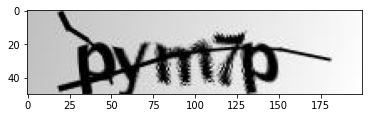

In [ ]:
test_img = cv2.imread('./drive/My Drive/Colab Notebooks/Datasets/pym7p.png')
plt.imshow(test_img)

In [ ]:
def decode_classes(path):
  name = str(path)
  return ["0_"+name[-9], "1_"+name[-8], "2_"+name[-7], "3_"+name[-6], "4_"+name[-5]]

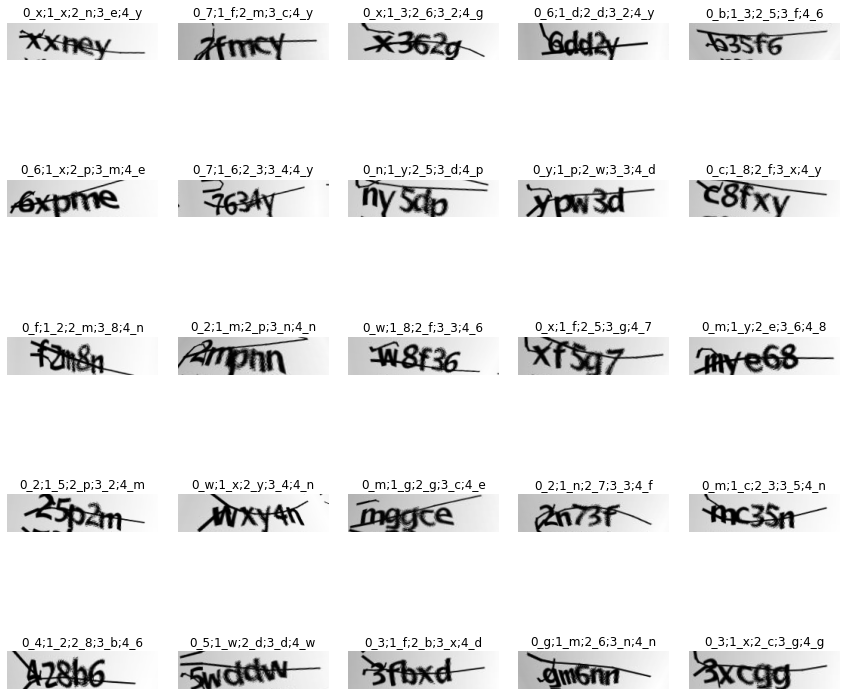

In [ ]:
path_img = pathlib.PosixPath("/content/drive/My Drive/Colab Notebooks/Datasets/")
fnames = get_image_files(path_img)
data = ImageDataBunch.from_name_func(path_img, fnames, decode_classes, ds_tfms=get_transforms(do_flip=False)).normalize(imagenet_stats)
data.show_batch(row=3, figsize=(12,12))

In [ ]:
loss = nn.CrossEntropyLoss()
def captcha_loss(inp:Tensor, target:Tensor):
  result = 0
  for i in range(5):
    start = i * 19
    end = (i + 1) * 19
    t1 = inp[:, start:end]
    t2 = target[:, start:end].argmax(dim=-1).long()
    result += loss(t1,t2)
  return result

In [ ]:
def good_captcha(nn_prediction:Tensor,target:Tensor):
  result = torch.ones(target.shape[0], device=target.device)
  for i in range(0,5):
    start = i*19
    end = (i+1)*19
    t1 = nn_prediction[:,start:end].argmax(dim=-1).long()
    t2 = target[:,start:end].argmax(dim=-1).long()
    tmp = (t1==t2).float()
    result *= tmp
  return result.mean()

In [ ]:
#########################
#                       #
#    Learning part      #
#                       #
#########################

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[good_captcha], loss_func=captcha_loss)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


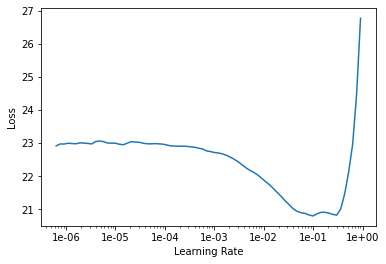

In [ ]:
learn.recorder.plot()

In [ ]:
learn.callbacks = [ShowGraph(learn)]

epoch,train_loss,valid_loss,good_captcha,time
0,21.957581,18.750704,0.000000,01:08
1,20.347118,18.927280,0.000000,00:03
2,18.842506,20.187401,0.000000,00:03
3,17.732141,17.426037,0.000000,00:03
4,16.699669,14.881209,0.000000,00:03
5,15.817533,14.580832,0.000000,00:03
6,14.989450,13.723898,0.000000,00:03
7,14.234062,13.303539,0.000000,00:03
8,13.623434,13.101841,0.000000,00:03
9,13.098936,13.053732,0.000000,00:03


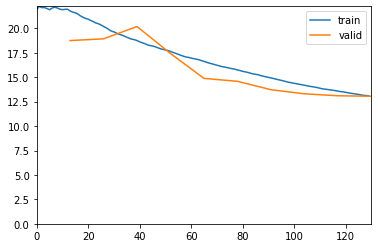

In [ ]:
learn.fit_one_cycle(10,slice(0.01))

In [ ]:
learn.save('resnet-learning-stage-1')

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


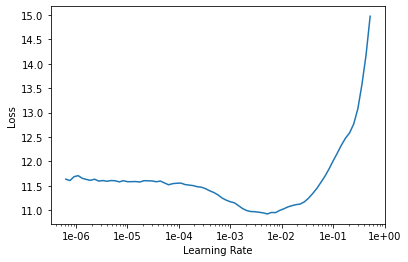

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,good_captcha,time
0,11.325159,12.306154,0.000000,00:03
1,10.803561,11.417236,0.000000,00:03
2,10.163599,10.663496,0.000000,00:03
3,9.490486,9.939538,0.004695,00:03
4,8.793433,9.099212,0.004695,00:03
5,8.058750,8.560201,0.004695,00:03
6,7.369967,8.182108,0.023474,00:03
7,6.669761,7.899258,0.023474,00:03
8,6.079788,7.626554,0.042254,00:03
9,5.574844,7.217720,0.042254,00:03


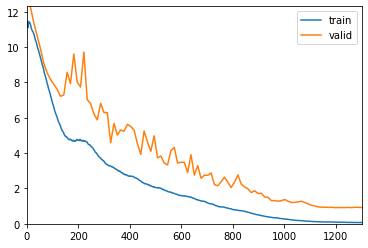

In [ ]:
learn.fit_one_cycle(100, max_lr=slice(3e-4, 3e-2))

In [ ]:
########################
#                      #
#     production       #
#                      #
########################

In [ ]:
symbols = ""
def decode(nn_output):
  result = ""
  for i in range(0,5):
    start = i*19
    end = (i+1)*19
    t1 = nn_output[2][start:end].argmax(dim=-1)
    result += data.classes[t1 + i*19][-1]
  return result

In [ ]:
learn.export()

###Test for one image

In [ ]:
img = open_image('./drive/My Drive/Colab Notebooks/Datasets/pym7p.png')

In [ ]:
str_res = decode(learn.predict(img))
str_res

'pym7p'

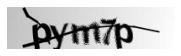

In [ ]:
img.show()

###Test for all images

In [ ]:
total_elem = 0
good_prediction = 0
for item in data.valid_ds:
  res = decode(learn.predict(item[0]))
  s = ""
  for i in str(item[1]).split(";"):
    s+=i[-1:]
  if res == s:
    good_prediction += 1
  total_elem +=1


In [ ]:
print("good prediction : " + str(good_prediction))
print("total elements : " + str(total_elem))
print("percentage : " + str(good_prediction/total_elem * 100)) 

good prediction : 166
total elements : 213
percentage : 77.93427230046949
